## Q学習(深層学習を使用しないアプローチ)で MountainCarを解く

In [1]:
from pathlib import Path

import gym

import matplotlib.pyplot as plt
import numpy as np
from IPython import display

from rl_mountain_car.utils import render_env, calc_reward
from rl_mountain_car.q_learning import QLearningAgent
%matplotlib inline

## Config

In [2]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')

In [3]:
# 総エピソード数
EPISODES = 50000

# log出力頻度
LOG_PERIOD = 1000
# epsilonの設定
INIT_EPSILON = 1.0
EPSILON_MIN = 0.005
EPSILON_DECAY = 500 * EPSILON_MIN / (EPISODES * env.spec.max_episode_steps)


# bin数
NUM_BINS = 40

# gamma
GAMMA = 0.9

# alpha
ALPHA = 0.1

# 保存先
DST = Path('./dst/q_table.npy')
DST.parent.mkdir(parents=True, exist_ok=True)

## 学習

In [4]:
agent = QLearningAgent(
    env,
    num_bins=NUM_BINS,
    init_epsilon=INIT_EPSILON,
    gamma=GAMMA,
    alpha=ALPHA
)
reward_log = []
best_reward = float('-inf')
for episode in range(EPISODES):
    state, _ = env.reset()
    is_done = False
    total_reward = 0
    num_trial = 0
    while not is_done:
        current_epsilon = agent.get_epsilon()
        if current_epsilon > EPSILON_MIN:
            agent.set_epsilon(current_epsilon - EPSILON_DECAY)
        action = agent.get_action(state)
        next_state, _, done, truncated, _ = env.step(action)
        is_done = done or truncated
        reward = calc_reward(state, next_state, num_trial, done)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        num_trial += 1
        total_reward += reward
    reward_log.append(total_reward)
    if total_reward > best_reward:
        print(f'best_reward: {best_reward} => {total_reward}')
        best_reward = total_reward
        agent.save_q(DST)
    if (episode + 1) % LOG_PERIOD == 0:
        print(f"episode :{episode + 1}, total reward : {total_reward}(num action = {num_trial}, epsilon = {agent.get_epsilon()})")

/usr/local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


best_reward: -inf => 5.307351436370482
best_reward: 5.307351436370482 => 8.347562991481027
best_reward: 8.347562991481027 => 9.851115428333287
best_reward: 9.851115428333287 => 13.516781151077339
best_reward: 13.516781151077339 => 15.162699029799114
best_reward: 15.162699029799114 => 15.821413288831536
best_reward: 15.821413288831536 => 16.375298639009088
best_reward: 16.375298639009088 => 17.714104125872836
best_reward: 17.714104125872836 => 21.074035365716554
best_reward: 21.074035365716554 => 21.349919140828206
best_reward: 21.349919140828206 => 21.549404637800762
best_reward: 21.549404637800762 => 23.083209410964628
best_reward: 23.083209410964628 => 24.349523587900876
episode :1000, total reward : 10.573827018553857(num action = 200, epsilon = 0.9499999999930111)
best_reward: 24.349523587900876 => 24.432162052151398
best_reward: 24.432162052151398 => 26.08025856151403
episode :2000, total reward : 9.778879400753794(num action = 200, epsilon = 0.8999999999860222)
best_reward: 26.08

## 報酬のログプロット

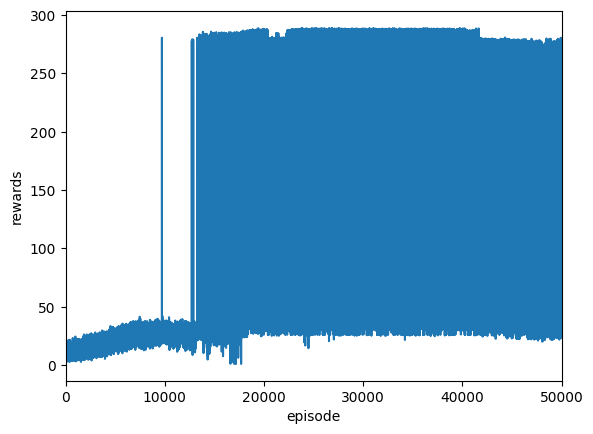

In [5]:
plt.plot(np.arange(1, len(reward_log) + 1), reward_log)
plt.xlim(-0.1, len(reward_log) + 1)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.show()

## 学習したエージェントにてMountainCar-v0を実行

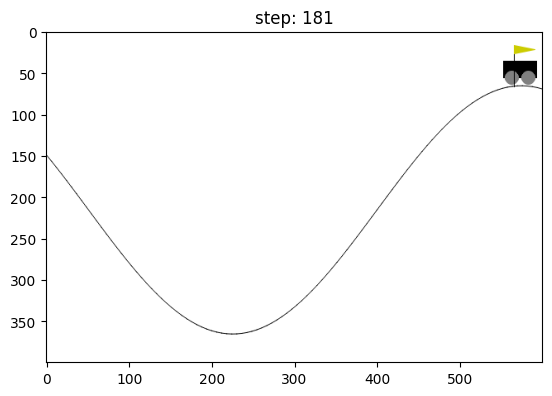

In [6]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
state = env.reset(seed=0)[0]
render_period = 10
# 同じ結果を返すようにしたいので、epsilon=0にする。
agent.set_epsilon(0)
agent.load_q(DST)
for i in range(200):
    action = agent.get_action(state)
    state, _, done, truncated, info = env.step(action)
    step_title = f'step: {i + 1}'
    if done:
        render_env(env, step_title)
        break
    if ((i + 1) % render_period == 0):
        render_env(env, step_title)
display.clear_output()
env.close()

## 学習済みモデルで動かしたい場合

ゴールに行かない学習が行われるケースがたまにある。

上手くいくケースは下記のセルを実行すると再現できるので、気になる場合は実行。

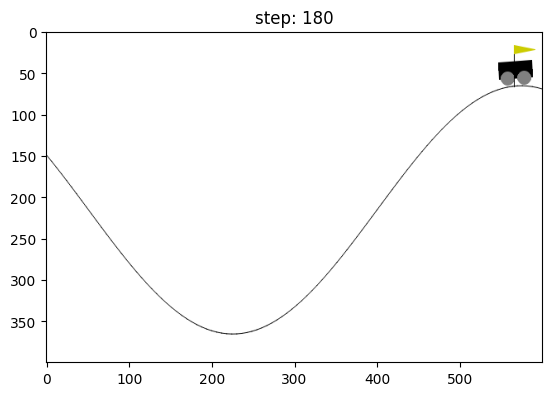

In [7]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
state = env.reset(seed=0)[0]
render_period = 10
# 同じ結果を返すようにしたいので、epsilon=0にする。
agent = QLearningAgent(
    env,
    num_bins=NUM_BINS,
    init_epsilon=INIT_EPSILON,
    gamma=GAMMA,
    alpha=ALPHA
)
agent.set_epsilon(0)
agent.load_q('./dst/example_q_table.npy')
for i in range(200):
    action = agent.get_action(state)
    state, _, done, truncated, info = env.step(action)
    step_title = f'step: {i + 1}'
    if done:
        render_env(env, step_title)
        break
    if ((i + 1) % render_period == 0):
        render_env(env, step_title)
display.clear_output()
env.close()